In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load mnist data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Adjusting to 0 ~ 1.0
x_train = x_train / 255.0
x_test = x_test / 255.0

print(x_train.shape, x_test.shape)

# (60000, 28, 28) (10000, 28, 28)
# 28x28 매트릭스가 60000개 /10000개 저장

(60000, 28, 28) (10000, 28, 28)


In [2]:
# CNN Input 형태로 변환
# 흑백 1채널 

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [3]:
# Dense Input 
# Keras functional API 아키텍처 확인을 목적으로 
# 임의의(동일한 데이터) 입력 데이터를 준비

x_train_dense = x_train.reshape(-1, 28, 28)
x_test_dense = x_test.reshape(-1, 28, 28)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 26, 26, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 13, 13, 16)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 28, 28)]     0                                            
____________________________________________________________________________________________

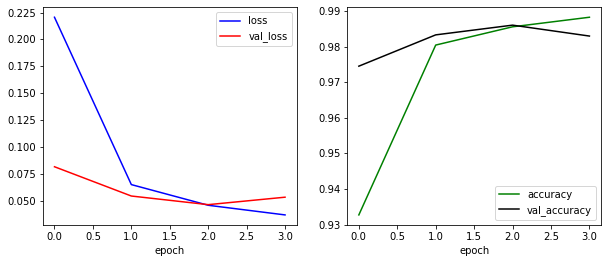

0.041560765355825424 0.986299991607666


In [5]:
# CNN Model 
Input_shape = (28,28,1)
img_input = tf.keras.layers.Input(shape=Input_shape)
h = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=16, activation='relu')(img_input)
h = tf.keras.layers.MaxPooling2D((2,2))(h)
h = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=32, activation='relu')(h)
h = tf.keras.layers.MaxPooling2D((2,2))(h)
h = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, activation='relu')(h)
h = tf.keras.layers.Flatten()(h)
img_out = tf.keras.layers.Dense(32, activation='relu')(h)

# Dense Model
Input_shape_dense = (28,28)
img_input_dense = tf.keras.layers.Input(shape=Input_shape_dense)
hh = tf.keras.layers.Flatten()(img_input_dense)
hh = tf.keras.layers.Dense(64, activation='relu')(hh)
hh = tf.keras.layers.Dropout(0.2)(hh)
hh = tf.keras.layers.Dense(64, activation='relu')(hh)
img_out_dense = tf.keras.layers.Dropout(0.2)(hh)

# 모델 결합
concatenated = tf.keras.layers.concatenate([img_out, img_out_dense])
predictions = tf.keras.layers.Dense(10, activation='softmax')(concatenated)

# API model 정의
model = tf.keras.Model(inputs=[img_input, img_input_dense], outputs=predictions)
model.summary()

# Compile and Train
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# 학습 조기 종료하기
# 참고 : # https://tykimos.github.io/2017/07/09/Early_Stopping/


# 검증 셋의 정확도가 (monitor, min_delta) '0'이상 증가하지 않을 때,(갑자기 정확도가 떨어지는 경우)
# '1' 에포크 만큼만 더 기다린 후(patience) 종료

stop_hist = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                          min_delta=0, patience=1, verbose=0, mode='auto')
history = model.fit([x_train, x_train_dense], y_train, epochs=20, 
                    validation_split=0.25, verbose=2, callbacks=[stop_hist])
# 에포크를 20으로 설정하고 몇 번 학습을 진행한 후 멈추는지 확인한다. (220519)

'''
monitor : 관찰하고자 하는 항목, ‘val_loss’나 ‘val_acc’가 주로 사용
min_delta : 개선되고 있다고 판단하기 위한 최소 변화량, 
            만약 변화량이 min_delta보다 적은 경우에는 개선이 없다고 판단
patience : 개선이 없다고 바로 종료하지 않고 개선이 없는 에포크를 얼마나 기다려 줄 것인 가를 지정.
            만약 10이라고 지정하면 개선이 없는 에포크가 10번째 지속될 경우 학습일 종료
verbose : 얼마나 자세하게 정보를 표시할 것인가를 지정 - (0, 1, 2)
mode : 관찰 항목에 대해 개선이 없다고 판단하기 위한 기준을 지정.
       예를 들어 관찰 항목이 ‘val_loss’인 경우에는 감소되는 것이 멈출 때 종료되어야 하므로, 
       ‘min’으로 설정
auto : 관찰하는 이름에 따라 자동으로 지정
min : 관찰하고 있는 항목이 감소되는 것을 멈출 때 종료
max : 관찰하고 있는 항목이 증가되는 것을 멈출 때 종료
'''

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r-', label='val_loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k-', label='val_accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()

# Model evaluate
test_loss, test_acc = model.evaluate([x_test, x_test_dense], y_test, verbose=0)

print(test_loss, test_acc)


In [10]:
model.save('model.h5')